In [1]:
#We load in the necessary libraries.
import pandas as pd
from collections import Counter
import re
from datetime import datetime
from tqdm import tqdm; tqdm.pandas()
import locale
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.special import softmax
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn import metrics
import joblib
from deep_translator import GoogleTranslator
import ast
from itertools import chain
import krippendorff

C:\Users\dubel\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#We read in the article contents.
df = pd.read_csv("03_contents_final.csv"); len(df)

30000

## extra row filters

In [3]:
#We define a function to clean the body text.
def get_clean_text(x):
    
    lst = []
    #We first want to filter out any wrongly scraped content.
    #In this case we define a list of sentences with promotional content, such as to take subscriptions.
    flter = ["Na de gekozen periode kunt u maandelijks opzeggen", 
             "Door mijn rekeningnummer in te vullen", 
             "Log in of maak een account aan"]
    
    #We first check if the value is correctly stored as a list.
    if isinstance(x, str):
        x = eval(x)
    else:
        pass
    
    #If so we loop over the paragraphs in the list of texts.
    for item in x:
        #We check if any of the filter items is present in the text.
        if not any(f in item for f in flter):
            #Furterhmore we replace all faulty symbols by simply empty spaces.
            result = item.replace("\\", " ").replace("\n", " ").replace("\t", " ")
            #If more then one space after each other exist, we replace it by a single space.
            result = re.sub(r" +", " ", result)
            #If we end up with NOT an empty string, we append it to the result list.
            if result != "":
                lst.append(result)
            else:
                pass
        else:
            pass
    #We return the list.
    return lst

#We also create a function to combine the paragraphs into one piece of string.
def get_text_one(x): 
    #If there is only one paragraph we simply store the first element of the list.
    if len(x) == 1:
        x = x[0]
    else:
        #In any other case we join the paragraphs by single spaces.
        x = " ".join(x)
    #We return our result.
    return x

#We also create a function to extract clean hyperlinks.
#That is hyperlinks to actual content, and not to prompotional content, such as puzzle pages or spotify pages.
def get_hyperlinks_clean(x):
    #We firstly evaluate the hyperlinks list truly as a list (instead of a string).
    x = eval(x)
    lst = []; result = []
    #We have a list of filters. These are hyperlinks we want to exclude.
    flter = ["uit-andere-media", "112-nieuws", "podcast", "www.113.nl", "renderer", "open.spotify", "puzzels", "sudoku", "survey.", "cloudfront.", "subscribe"]
    for item in x:
        #We firstly check whether the items in the hyperlink value are correclty links.
        #We do so by checking wheter either www or http is present in the links.
        if "www." in item or "http" in item:
            #If so we append it to a new list.
            lst.append(item)
        else:
            pass
    #We loop over the items of this list.
    for item in lst:
        #And exclude those which have any of the filter tages in the them.
        if not any(f in item for f in flter):
            result.append(item)
    #We return the result.
    return result

In [4]:
#We remove all rows which have more then 5 missing values.
threshold = 5; df = df.dropna(thresh=len(df.columns) - threshold); print(len(df))

29845


In [5]:
#We create a column with a clean text using the earlier defined function.
df["txt_text_clean"] = df.txt_text.progress_apply(lambda x: get_clean_text(x))

100%|██████████████████████████████████████████████████████████████████████████| 29845/29845 [00:03<00:00, 7528.82it/s]


In [6]:
#We create a column with a single combined text using the earlier defined function.
df["txt_text_one"] = df.txt_text_clean.progress_apply(lambda x: get_text_one(x))

100%|████████████████████████████████████████████████████████████████████████| 29845/29845 [00:00<00:00, 359642.60it/s]


In [7]:
#We exclude the articles which do not have text at all.
df = df[df.txt_text_one != ""]; print(len(df))

29526


In [8]:
#We create a column with the length of the texts.
df["text_length"] = df.txt_text_one.progress_apply(lambda x: len(str(x)))

100%|███████████████████████████████████████████████████████████████████████| 29526/29526 [00:00<00:00, 1109577.19it/s]


In [9]:
#We create a maximum for the length of the text, namely the mean plus three times the standard deviation
txt_length_max = round(np.mean(df.text_length) + 3*np.std(df.text_length)); print(txt_length_max)

10206


In [10]:
#We only include rows with texts below the maximum.
df = df[df.text_length < txt_length_max]; print(len(df))

28934


In [11]:
#We apply our clean hyperlink function.
df["hyperlinks_clean"] = df.hyperlinks.progress_apply(lambda x: get_hyperlinks_clean(x))

100%|████████████████████████████████████████████████████████████████████████| 28934/28934 [00:00<00:00, 103319.54it/s]


In [12]:
#We count the number of hyperlinks
df["n_hyperlinks"] = df.hyperlinks_clean.progress_apply(lambda x: len(x))

100%|███████████████████████████████████████████████████████████████████████| 28934/28934 [00:00<00:00, 1010861.71it/s]


In [13]:
#We create a hyperlink count maximum. Namely the 999th quantile.
n_hyperlinks_max = np.quantile(df.n_hyperlinks, .999); round(n_hyperlinks_max)

14

In [14]:
#We only include articles with less then the maximum number of hyperlinks.
df = df[df.n_hyperlinks < n_hyperlinks_max]; print(len(df))

28901


In [15]:
#We write away the article data so far.
df.to_csv("ARTICLE_DATA_clean.csv")

## monthly overview

In [16]:
#We quickly transform the datePublished value to a true datetime format.
df["datePublished"] = pd.to_datetime(df.datePublished,  format="mixed", utc=True)

In [17]:
#We extract the month of the datetimes.
df["dateMonth"] = df.datePublished.dt.month

In [18]:
#We create a dataframe which contains per outlet and month the number of rows.
df_monthly = df.groupby(["news_source", "dateMonth"]).size().reset_index(name="n")

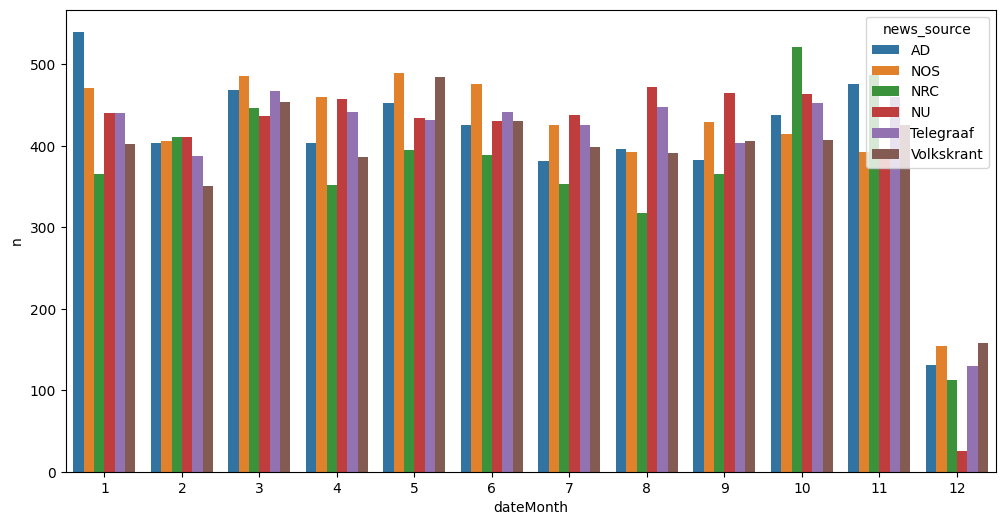

In [19]:
#We plot this data.
#Highlighting the number of cases per outlet per month.
plt.figure(figsize=(12, 6))
sns.barplot(data=df_monthly, x="dateMonth", y="n", hue="news_source")
plt.show()

## preprocessing

### author

In [20]:
#We define a function to clean the author names.
def get_author_clean(x):
    #We strip away irrelevant characters.
    x = x.strip("['']")
    #Similarly we strip away the author introduction term.
    x = re.sub("door ", "", x, flags=re.IGNORECASE)
    return x

#We define a function to categorize the authors.
def get_author_categories(x):
    #If the string is empty, it is categorized as absent.
    if x == '':
        x = "absent"
    #If the string contains generic names it is categorized as editor(s).
    elif "redact" in x.lower() or "correspondent" in x.lower() or "verslaggever" in x.lower():
        x = "editor(s)"
    #If the author contains a term starting with automatic, then it is coded as such.
    elif "automat" in x.lower():
        x = "automatic"
    #If the author contains a sequence of two capitalized words, then it is assumed to be a full name.
    #These are categorized as inidividual author(s).
    elif re.search("[A-Z|ÇÖ|][a-z|öéïüñá|\.].*[A-Z|ÇÖ][a-z|öéïüñá]", x):
        x = "individual author(s)"
    #If the author is just a reference to the outlet, then it is categorized as news website.
    elif any(item in x for item in list(set(df.news_source))):
        x = "news website"
    #If it refers to the dutch press agency it is coded as such.
    elif x == "ANP":
        x = "press agency"
    #In all other cases it is coded as other.
    else:
        x = "other"
    return x

#In a last step we categorize our earlier categories on the basis of transparency.
def get_tp_authors(x):
    #Individual authors are explicit.
    if x == "individual author(s)":
        x = "explicit"
    #Simply references to editor(s) or news websites in a generic way and press agencies are coded abstract.
    elif x in ["editor(s)", "news website", "press agency"]:
        x = "abstract"
    #In the case of automatic or other author forms, we will refer to it as other.
    elif x == "automatic" or x == "other":
        x = "other"
    return x

In [21]:
#We use these functions to create new columns
df["author_clean"] = df.txt_author.progress_apply(lambda x: get_author_clean(x))
df["author_categories"] = df.author_clean.progress_apply(lambda x: get_author_categories(x))
df["tp_authors"] = df.author_categories.progress_apply(lambda x: get_tp_authors(x))

100%|███████████████████████████████████████████████████████████████████████| 28901/28901 [00:00<00:00, 1634590.27it/s]


In [22]:
#We print the occurance of author categories and their transparency categories.
print(Counter(df.author_categories))
Counter(df.tp_authors)

Counter({'individual author(s)': 14886, 'absent': 7890, 'editor(s)': 5829, 'other': 111, 'automatic': 97, 'news website': 79, 'press agency': 9})


Counter({'explicit': 14886, 'absent': 7890, 'abstract': 5917, 'other': 208})

### author contact & bio

In [23]:
#We create a function to extract the author contact additions.
def get_contact_additions(x):
    
    #We make sure the byline is interpreted as a list.
    byline = eval(x["txt_author_links"])
    #And that the text is interpreted as a string.
    text = str(x["txt_text"])
    hyperlinks = x["hyperlinks"]
    
    #We define a regular expression to look for emails in both the text as hyperlinks.
    #We extract and store those.
    text_mails = re.findall(r"\b\w+@\w+\b", text)
    hyperlinks_mails = re.findall(r"\b\w+@\w+\b", hyperlinks)
    
    #We combine all hits together.
    y = byline + text_mails + hyperlinks_mails
    
    #We once again create a filter for all irrelevant byline elements.
    flter = ["uit-andere-media", "abonnement", "uitgelicht", "sudoku", "puzzels", "/nieuws/", "share", "download"]
    #We make sure that our list is interpreted as a list.
    y = eval(str(y))
    #If the list only has a length of 0 then there are no byline additions.
    if len(y) == 0:
        y = ["absent"]
    else:
        lst = []
        #In every other case we loop over the items in the byline elements list.
        for item in y:
            #If the item contains any of the filter elements then we define it is wrong.
            if any(f in item for f in flter):
                item = "wrong"
            #If the terms auteur or redactie are in it, then we store it as other.
            if "/auteur/" in item.lower() and "redactie" in item.lower():
                item = "other"
            #If an email symbol is present we store it as mail.
            if "@" in item:
                item = "mail"
            #If a twitter link is present we store it as a handle.
            #Pretesting highlighted that no other social was every present in the byline.
            elif re.search("https://twitter.com/\w+?", item):
                item = "handle"
            #We assess whether individual author names are present in the element.
            #If so we code it as bio.
            elif re.search("/auteur/[A-ZÇÖa-z].*(-| )[A-ZÇÖa-z]", item) or "ombudsman" in item:
                item = "bio"   
            #We also look for specific instances in which they are referred to via a tag.
            elif "onze-mensen" in item or re.search("tag/[A-ZÇÖa-z].*%", item):
                item = "bio"
            #If http is in the item it is wrong.
            elif "http" in item:
                item = "wrong"
            #The rest is stored as other.
            else:
                item = "other"
            #We append the items to a new list.
            lst.append(item)
        #We redefine y, with all unique elements of the list.
        y = list(set(lst))
    
    #We return this new list.
    return y

#We create a function to assess wheter contact info is present.
def get_contact(x):
    x = eval(str(x))
    #We simply check if our earlier created list of categories has a mail or handle in it.
    if "mail" in x or "handle" in x:
        return True
    else:
        return False
    
#We also do so for bio info.
def get_bio(x):
    x = eval(str(x))
    #We simply check if bio is in the categories list.
    if "bio" in x:
        return True
    else:
        return False

In [24]:
#We create the author additions column.
df["author_additions"] = df.progress_apply(lambda x: get_contact_additions(x), axis=1)

100%|██████████████████████████████████████████████████████████████████████████| 28901/28901 [00:03<00:00, 7251.91it/s]


In [25]:
#We look at the occurances.
Counter(df["author_additions"].astype(str))

Counter({"['absent']": 18688,
         "['bio']": 4173,
         "['bio', 'other']": 3279,
         "['other']": 1592,
         "['mail']": 357,
         "['handle', 'mail']": 158,
         "['mail', 'other']": 147,
         "['wrong']": 140,
         "['handle']": 125,
         "['handle', 'other']": 86,
         "['bio', 'mail', 'other']": 61,
         "['wrong', 'other']": 45,
         "['bio', 'mail']": 35,
         "['handle', 'mail', 'other']": 5,
         "['wrong', 'handle', 'other']": 4,
         "['wrong', 'bio']": 3,
         "['wrong', 'mail']": 1,
         "['wrong', 'handle']": 1,
         "['bio', 'wrong']": 1})

In [26]:
#We define the boolean columns for contact and bio info.
df["tp_contact"] = df.author_additions.progress_apply(lambda x: get_contact(x))
df["tp_bio"] = df.author_additions.progress_apply(lambda x: get_bio(x))

100%|████████████████████████████████████████████████████████████████████████| 28901/28901 [00:00<00:00, 135566.59it/s]


In [27]:
#We count the presence of contact info
Counter(df.tp_contact)

Counter({False: 27921, True: 980})

In [28]:
#We count the presence of bio info
Counter(df.tp_bio)

Counter({False: 21349, True: 7552})

### detailed timestamps

In [29]:
#We define a function to extract the info from the timestamps.
def get_timestamps(x):
    
    #We set our timezone to be sure.
    locale.setlocale(locale.LC_TIME, "nl_NL")
    
    #We make sure that our column is interpreted as a list.
    x = eval(str(x))
    
    #If the list is emptu, then we refer to it as none.
    if len(x) == 0:
        x = ["none"]
        
    else:
        #In every other instance we define an empty list.
        lst = []
        #We also define a list of possible date formats.
        formats = ["%d %B %Y", "%d %b. %Y", "%d-%m-%y, %H:%M", "%d %B %Y, %H:%M",
                   "%d %b %Y om %H:%M", "%A %d %B %Y, %H:%M", "%A %d %B, %H:%M", "%d-%m-%Y"]
        
        #We loop over the items in the timestamps list.
        for item in x:
            #We strip the item and remove the updated term.
            item = item.strip(""); item = re.sub("aangepast: ", "", item, flags=re.IGNORECASE)
            result = None
            
            for f in formats:
                #We loop over the formats and try to extract a datetime from it.
                try:
                    #If succesfull we append date as an item to the new list.
                    result = datetime.strptime(item, f); lst.append("date")
                except:
                    #If unsuccesfull we continue looping over the formats.
                    continue
            
            #We also look for wrong items, such as when it says the duration to read the article.
            if re.search("\d+ minu", item) or "Beeld" in item:
                result = "wrong"; lst.append(result)
            
            #If the item contains the term update we store it as such.
            elif "Update" in item:
                result = "update"; lst.append(result)
            
            #If nothing is found we store it as other.
            elif result == None:
                result = "other"
                
        x = list(lst)
    
    #We return the results.
    return x

#We create a function to recategorize our timestamp elements.
def get_txt_timestamps_cat(x):
    #If there is more then one date in the byline we assume that both a date and update is present.
    if x.count("date") > 1:
        return "date and update"
    #The same goes if a date and update is present.
    elif x.count("date") == 1 and "update" in x:
        return "date and update"
    #If not so, there is purely a date.
    elif x.count("date") == 1 and "update" not in x:
        return "date"
    #All other cases are stored as none.
    else:
        return "none"

#We create a function to assess whether an article changed.
def get_changed(x):
    dp = x["datePublished"]
    dm = x["dateModified"]
    
    #If the datePublished tag is equal to the dateModified tag then it did not change.
    if dp == dm:
        return False
    #If no dateModified tag is present then it did not change.
    elif pd.isna(dm):
        return False
    #If they are not equal then it did change.
    elif dp != dm:
        return True   

#We recategorize the timestamps on the basis of transparency.
def tp_timestamp(x):
    
    byline = x["txt_timestamps_cat"]
    meta_changed = x["changed"]
    
    #If the byline only contains a date and the article did not change, then we code it as no change.
    if byline == "date" and meta_changed == False:
        return "no change"
    #If the byline only contains a date while the article did change, then we code it as change undisclosed.
    elif byline == "date" and meta_changed == True:
        return "change undisclosed"
    #If the change was disclosed then we code it as change disclosed.
    elif byline == "date and update" and meta_changed == True:
        return "change disclosed"
    #The rest will be coded as other.
    else:
        return "other"

In [30]:
#We add the timestamps clean column by its function.
df["txt_timestamps_clean"] = df.txt_timestamps.progress_apply(lambda x: get_timestamps(x))

100%|██████████████████████████████████████████████████████████████████████████| 28901/28901 [00:05<00:00, 4831.44it/s]


In [31]:
#We print the occurance of every combination.
Counter(df.txt_timestamps_clean.astype(str))

Counter({"['date']": 14679,
         "['date', 'date']": 4664,
         "['wrong', 'date']": 2889,
         "['date', 'wrong']": 2632,
         "['update', 'wrong', 'date']": 950,
         "['update', 'date', 'wrong']": 850,
         "['date', 'wrong', 'update']": 705,
         "['date', 'update', 'wrong']": 598,
         "['wrong', 'date', 'update']": 259,
         "['wrong', 'update', 'date']": 227,
         "['none']": 210,
         "['update', 'date']": 79,
         '[]': 71,
         "['date', 'update']": 46,
         "['date', 'date', 'date']": 42})

In [32]:
#We recategorize them accoriding to our function.
df["txt_timestamps_cat"] = df.txt_timestamps_clean.progress_apply(lambda x: get_txt_timestamps_cat(x))

100%|███████████████████████████████████████████████████████████████████████| 28901/28901 [00:00<00:00, 1351645.02it/s]


In [33]:
Counter(df.txt_timestamps_cat.astype(str))

Counter({'date': 20200, 'date and update': 8420, 'none': 281})

In [34]:
#We create a column for the output of the changed function.
df["changed"] = df.progress_apply(lambda x: get_changed(x), axis=1)

100%|████████████████████████████████████████████████████████████████████████| 28901/28901 [00:00<00:00, 149876.40it/s]


In [35]:
Counter(df.changed.astype(str))

Counter({'True': 25370, 'False': 3531})

In [36]:
#And lastly we also do so for the transparency of the timestamps
df["tp_timestamp"] = df.progress_apply(lambda x: tp_timestamp(x), axis=1)

100%|████████████████████████████████████████████████████████████████████████| 28901/28901 [00:00<00:00, 144575.63it/s]


In [37]:
Counter(df.tp_timestamp.astype(str))

Counter({'change undisclosed': 16678,
         'change disclosed': 8420,
         'no change': 3522,
         'other': 281})

### error corrections

In [38]:
#We define a function to detect error corrections.
def get_error_correction(text, max_distance=20):
    #We firstly strip and lower the text.
    text = str(text).strip().lower()
    #We then look for a pattern in which within 20 words the words version and earlier are close to each other. Or synonyms for it.
    pattern = f"\\b(eerder|vorig).{{0,{max_distance}}}\\b(versie|publicatie|bericht\\b)|\\b(versie|publicatie).{{0,{max_distance}}}\\b(eerder|vorig)"
    result = re.search(pattern, string=text)
    #We return the result as a boolean, being either present yes or no.
    return bool(result)

In [39]:
#We add it as a new column.
df["error_correction"] = df.txt_text.progress_apply(lambda x: get_error_correction(x))

100%|█████████████████████████████████████████████████████████████████████████| 28901/28901 [00:02<00:00, 12042.24it/s]


In [40]:
Counter(df.error_correction.astype(str))

Counter({'False': 28678, 'True': 223})

In [41]:
#Of the hits we get a random sample of 30.
df_error_corr_sample = df[df.error_correction==True][["txt_text_one", "error_correction"]].sample(30, random_state=1)

In [42]:
#We write this away to excel.
df_error_corr_sample.to_excel("error_corr.xlsx")

In [43]:
#We read in a coded version of the sample.
df_error_corr_coded = pd.read_csv("03_error_coded.csv",  sep=";", index_col=0)

In [44]:
#We have an agreement with the regular expression of 97%.
round(df_error_corr_coded.error_corr_manual.mean(), 2)

0.97

In [45]:
#We create a function to connect these textual disclosures to whether the text actually changed.
def get_tp_error(x):
    error = x["error_correction"]
    meta_changed = x["changed"]
    
    #If it changed and there is an error disclosure, we return change disclosed.
    if meta_changed == True and error == True:
        return "change disclosed"
    #If it changed and no error disclosure is present, we return change undisclosed.
    elif meta_changed == True and error == False:
        return "change undisclosed"
    #If there is no change, we return it.
    elif meta_changed == False:    
        return "no change"
    #For all else we return other.
    else:
        return "other"    

In [46]:
#We add it as a column
df["tp_error"] = df.progress_apply(lambda x: get_tp_error(x), axis=1)

100%|████████████████████████████████████████████████████████████████████████| 28901/28901 [00:00<00:00, 154185.13it/s]


In [47]:
Counter(df.tp_error.astype(str))

Counter({'change undisclosed': 25152,
         'no change': 3531,
         'change disclosed': 218})

In [49]:
df.news_source

0               NRC
1               NRC
2        Volkskrant
3               NOS
4         Telegraaf
            ...    
29993           NOS
29995            NU
29996           NOS
29998            AD
29999    Volkskrant
Name: news_source, Length: 28901, dtype: object

### hyperlinking

In [50]:
#To assess what kind of data files, for document hyperlinking, are referred to, we create a function.
def get_data_types(x):
    links = x["hyperlinks_clean"]
    
    lst = []
    #We loop over the cleaned hyperlinks.
    for item in links:
        #To be sure we put them in lowercase.
        item = item.lower()
        #We try to look through a regular expression for possible existance of file extensions.
        #Presumably these are past a dot at the end of the hyperlink (e.g. .pdf).
        matches = re.search(r"\.([^\.]*)$", item)
        if matches:
            #If there is a correct match we append it to a list.
            match = matches.group(1)
            if len(match) < 10 and not re.search(r"/|\\|\d+|htm", match):
                lst.append(match)
        else:
            pass
    return set(lst)

#We also create a function to get the stems of websites.
def get_link_stems(x):
    result = []
    #We loop over links.
    for item in x:
        try:
            #We try, through a regular expression, to extract the middle part of a web adress.
            hit = re.search(r"(http(s)?:)?//(www.)?(\w+)", item).group(4)
            #If found we append it to a list.
            result.append(hit)
        except:
            #If we do not find any, we append wrong to the list.
            result.append("wrong")
    #We return our results.
    return result

#Lastly we define a function to categorize the hyperlinks on their transparency level.
def get_hyperlinks_cat(x):
    links = x["hyperlinks_clean"]
    stems = x["link_stems"]
    source = x["news_source"].lower()
    
    #We first assess what the parent company is of the news outlet.
    #For AD, Volkskrant & NU it is DPG.
    if source in ["ad", "volkskrant", "nu"]:
        parent = "DPG"
    #For Telegraaf and NRC it is Mediahuis.
    elif source in ["telegraaf", "nrc"]:
        parent = "Mediahuis"
    else:
        #For NOS we will simply refer to it as NOS.
        parent = "NOS"
    
    lst = []
    #We loop over the links and stems of the links.
    for item, stem in zip(links, stems):
        item = item.lower()
        #If the link simply contains the news outlet itself then it is an internal link.
        if re.search(fr"(www.|http).*{source}.\w+", item):
            lst.append("internal link")
        #If it contains any of the common file extensions, then it is document linking.
        elif re.search(r"(.pdf|.epdf|.doc|.xls|.csv|.txt|.jpeg|.jpg|.png|.gif|.mp4|.avi|.ppt|.m4a|.mp3|.wav|.zip)", item) or "document" in item:
            lst.append("document")
        #If it refers to a stem of any of its family members, then it is family linking.
        elif re.search(r"(www.|http).*\w+.\w+", item) and stem in parents[parent].values:
            lst.append("family link")
        #If it refers to any other stem then within its own family, then it is external linking.
        elif re.search(r"(www.|http).*\w+.\w+", item) and stem not in parents[parent].values:
            lst.append("external link")
        #The rest is coded as other.
        else:
            lst.append("other")
    return lst

#Lastly we create a function which simply counts the occurance of each of these link types within the created list.
def get_tp_source_links(x):
    return x.count("internal link"), x.count("document"), x.count("family link"), x.count("external link")

In [51]:
#We create a column with the clean link stems.
df["link_stems"] = df.hyperlinks_clean.progress_apply(lambda x: get_link_stems(x))

100%|████████████████████████████████████████████████████████████████████████| 28901/28901 [00:00<00:00, 733534.92it/s]


In [52]:
#We count the most common stems.
Counter(df[["news_source", "link_stems"]].explode("link_stems").dropna().link_stems).most_common(10)

[('nos', 3794),
 ('ad', 3174),
 ('nrc', 2253),
 ('volkskrant', 1510),
 ('nu', 1365),
 ('twitter', 832),
 ('youtube', 477),
 ('instagram', 178),
 ('nytimes', 155),
 ('rijksoverheid', 154)]

In [54]:
#We read in the related parent company sites.
parents = pd.read_excel("03_family.xlsx"); parents = parents.fillna("")

In [56]:
#We create a latex table for it.
print(parents.to_latex())

\begin{tabular}{llll}
\toprule
 & NOS & DPG & Mediahuis \\
\midrule
0 & nos & ad & telegraaf \\
1 & 1limburg & volkskrant & nrc \\
2 & nhnieuws & nu & metro \\
3 & omroepbrabant & trouw & gelderlander \\
4 & omroepflevoland & bndestem & ijmuidercourant \\
5 & omropfryslan & bd & noordhollandsdagblad \\
6 & gld & gelderlander & haarlemsdagblad \\
7 & omroepwest & destentor & gooieneemlander \\
8 & omroepzeeland & ed & leidschdagblad \\
9 & rijnmond & parool & dvhn \\
10 & rtvdrenthe & pzc & frieschdagblad \\
11 & rtvnoord & tubantia & lc \\
12 & rtvoost &  &  \\
13 & rtvutrecht &  &  \\
\bottomrule
\end{tabular}



In [57]:
#We create a function to extract all possible data types.
df["data_types"] = df.progress_apply(lambda x: get_data_types(x), axis=1)

100%|█████████████████████████████████████████████████████████████████████████| 28901/28901 [00:00<00:00, 59681.33it/s]


In [58]:
#We print the most occuring data types present.
#We used this to inform our regular expression for document hyperlinking.
print(Counter(df["data_types"].astype(str)))

Counter({'set()': 28455, "{'pdf'}": 236, "{''}": 73, "{'aspx'}": 42, "{'nl'}": 25, "{'php'}": 17, "{'com'}": 5, "{'jpg'}": 5, "{'', 'php'}": 3, "{'ece'}": 3, "{'', 'pdf'}": 3, "{'cms'}": 3, "{'org'}": 2, "{'net'}": 2, "{'cnn'}": 2, "{'books'}": 1, "{'', 'aspx'}": 1, "{'jsp'}": 1, "{'', 'aspx', 'pdf'}": 1, "{'amp'}": 1, "{'for'}": 1, "{'datema'}": 1, "{'meachen'}": 1, "{'uk'}": 1, "{'mfa'}": 1, "{'gpx', 'pdf'}": 1, "{'pdf ', 'txt'}": 1, "{'terrorism'}": 1, "{'_ehrlich', 'pdf'}": 1, "{'png'}": 1, "{'_allegro'}": 1, "{'stm'}": 1, "{'gif'}": 1, "{'ds'}": 1, "{'fruithof'}": 1, "{'android', 'app'}": 1, "{'pdf?dd'}": 1, "{'ovpay'}": 1, "{'aspx', 'pdf'}": 1, "{'nl', 'pdf'}": 1})


In [59]:
#We create the categorized hyperlinking lists as a column.
df["hyperlinks_cat"] = df.progress_apply(lambda x: get_hyperlinks_cat(x), axis=1)

100%|█████████████████████████████████████████████████████████████████████████| 28901/28901 [00:00<00:00, 52935.03it/s]


In [60]:
#We create seperate columns with the counts of each type of hyperlink.
df[["tp_internal", "tp_document", "tp_family", "tp_external"]] = df.hyperlinks_cat.progress_apply(lambda x: pd.Series(get_tp_source_links(x)))

100%|█████████████████████████████████████████████████████████████████████████| 28901/28901 [00:02<00:00, 12326.55it/s]


In [63]:
#We print the means of each hyperlinking type count.
print(round(np.mean(df["n_hyperlinks"]), 2))
print(round(np.mean(df["tp_internal"]), 2))
print(round(np.mean(df["tp_family"]), 2))
print(round(np.mean(df["tp_external"]), 2))
print(round(np.mean(df["tp_document"]), 2))

0.8
0.42
0.04
0.32
0.02


In [64]:
#We also assess the means of each outlet of overall hyperlinking.
df.groupby("news_source").n_hyperlinks.mean()

news_source
AD            0.817439
NOS           1.241945
NRC           1.419398
NU            0.564503
Telegraaf     0.050517
Volkskrant    0.744568
Name: n_hyperlinks, dtype: float64

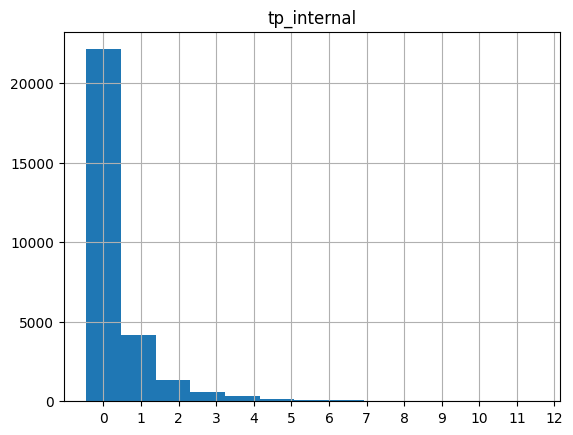

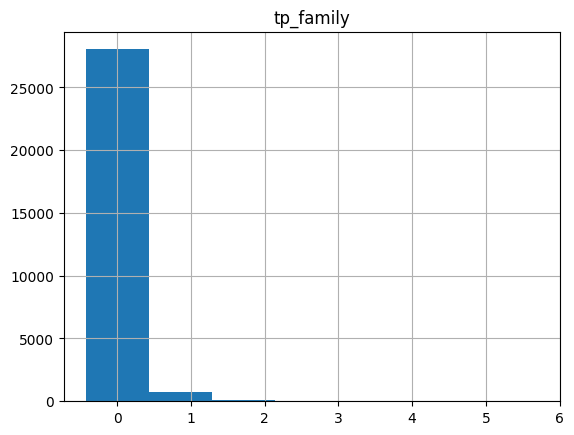

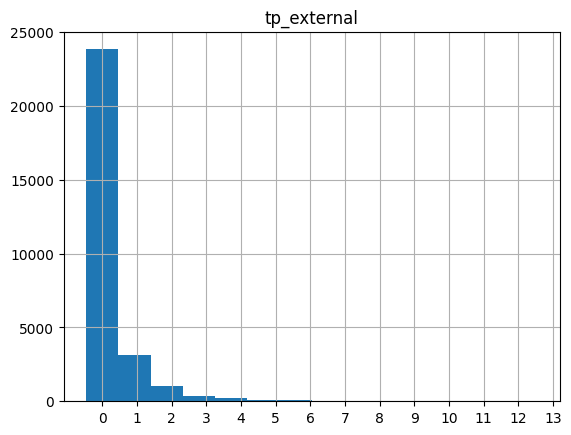

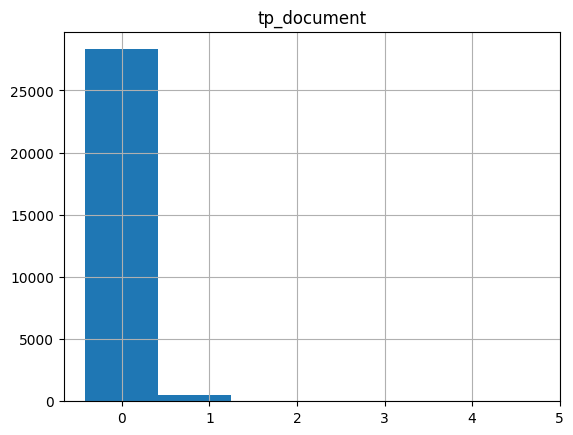

In [66]:
#We quickly assess the distributions of each of these counts by histplots.
for x in ["tp_internal", "tp_family", "tp_external", "tp_document"]:
    df[[x]].hist(bins = len(df[[x]].value_counts()), align="left")
    plt.xticks(range(int(min(df[x])), int(max(df[x])) + 1))
    plt.show()

### sourcing sampling

In [68]:
#Since we limit sourcing detection to the first two paragraphs we combine the first two items of the paragraph list.
df["intro"] = df.txt_text_clean.progress_apply(lambda x: " ".join(x[:2]))

100%|████████████████████████████████████████████████████████████████████████| 28901/28901 [00:00<00:00, 836308.56it/s]


In [69]:
#We then tokenize this newly created intro column into sentences in a list.
df["intro_sentences"] = df.intro.progress_apply(lambda x: sent_tokenize(x))

100%|██████████████████████████████████████████████████████████████████████████| 28901/28901 [00:04<00:00, 7068.10it/s]


In [70]:
#We assess what the median sentence length is of the intro.
intro_sen_n_max = round(np.median(df.intro_sentences.apply(lambda x: len(x)))); print(intro_sen_n_max )

5


In [71]:
#We truncate the intro length by this median intro length.
df["intro_1st_5_sent"] = df.intro_sentences.progress_apply(lambda x: x[:intro_sen_n_max])

100%|███████████████████████████████████████████████████████████████████████| 28901/28901 [00:00<00:00, 1018651.93it/s]


In [72]:
#We create a new dataframe in which we extract the index, news_source, and truncated intro column.
#We then explode the list of intro sentences. This makes that every row is a sentence of an intro.
df_intro = df[["index", "news_source", "intro_1st_5_sent"]].explode("intro_1st_5_sent").reset_index().drop(columns="level_0").rename(columns={"intro_1st_5_sent": "sent"})

In [73]:
#We then add a within index for the intro, thus indicating wheter it is the first sentence of the intro, the second, et cetera.
#We also create an empty column named source presence, which we will code ourselves manually.
df_intro["sent_index"] = df_intro.groupby("index").cumcount(); df_intro["source_presence"] = ""

In [74]:
#We then randomly shuffle this data.
df_intro_sample = df_intro.sample(frac=1, random_state=1)

In [75]:
#We write it away as an excel file.
df_intro_sample.to_excel("df_intro_sent_sample.xlsx")

### sourcing categories

NOTE: See script 11 to see all taken in between steps. This script was run from a server due to demanding models to run.

In [76]:
#We read in a version of the endproduct of the sourcing pipeline.
df_sourcing = pd.read_csv("03_sourcing_pipeline_product.csv", index_col=0)

In [77]:
#We count the occurance of each predicted category.
Counter(df_sourcing.p_sourcing_cat)

Counter({3: 15010, 2: 8895, 0: 2344, 1: 384})

In [79]:
#We collapse the data back to the intro level, making a list per intro of all predicted values.
df_sourcing = (df_sourcing[["news_source", "index", "p_sourcing_cat"]].groupby(["index"]).agg({"p_sourcing_cat": lambda x: x.tolist()})).reset_index()

In [81]:
#We merge it with our larger file.
df = df.merge(df_sourcing, how="left")

In [82]:
#For all missing instances we fill 0.
df["p_sourcing_cat"] = df.p_sourcing_cat.fillna(0)

In [83]:
#We define a function to give the values readable names.
def get_intro_sourcing_cat(x):
    #If the entire intro has no sourcing we return absent.
    if x == 0:
        return ["absent"]
    else:
        output = []
        for item in x:
            #If the item in the list is zero we return absent.
            if item == 0:
                output.append("absent")
            #If the item is 1 we return anonymous.
            elif item == 1:
                output.append("anonymous")
            #For 2 we return opaque.
            elif item == 2:
                output.append("opaque")
            #And 3 is explicit.
            elif item == 3:
                output.append("explicit")
        return output

In [85]:
#We add this as a new columm.
df["sourcing"] = df.p_sourcing_cat.progress_apply(lambda x: get_intro_sourcing_cat(x))

100%|███████████████████████████████████████████████████████████████████████| 28901/28901 [00:00<00:00, 1342439.26it/s]


In [86]:
#We count the presence of all sourcing combinations in the intro.
Counter(df.sourcing.astype(str)).most_common(10)

[("['absent']", 12852),
 ("['explicit']", 5534),
 ("['opaque']", 2807),
 ("['explicit', 'explicit']", 1525),
 ("['explicit', 'opaque']", 953),
 ("['opaque', 'explicit']", 938),
 ("['opaque', 'opaque']", 567),
 ("['explicit', 'explicit', 'explicit']", 327),
 ("['explicit', 'absent']", 243),
 ("['absent', 'explicit']", 240)]

In [87]:
#We define a simple function to assess what the highest transparency tier is in the list of sources in the intro.
def get_tp_sourcing(x):
    if "explicit" in x:
        return "explicit"
    elif "opaque" in x:
        return "opaque"
    elif "anonymous" in x:
        return "anonymous"
    elif "absent" in x:
        return "absent"

In [88]:
#We add it as a column.
df["tp_sourcing"] = df.sourcing.progress_apply(lambda x: get_tp_sourcing(x))

100%|███████████████████████████████████████████████████████████████████████| 28901/28901 [00:00<00:00, 1670588.61it/s]


In [86]:
#We count the presence on the intro level of the highest transparency tier.
Counter(df.tp_sourcing)

Counter({'absent': 12927, 'explicit': 11921, 'opaque': 3868, 'anonymous': 185})

In [89]:
#We randomly sample 30 intro texts.
sourcing_validation = df[["index", "news_source", "intro_1st_5_sent", "tp_sourcing"]].groupby("tp_sourcing").sample(30, random_state=1)

In [90]:
#We write it away to excel.
sourcing_validation.to_excel("sourcing_validation.xlsx")

In [91]:
#We read in the annotated version.
sourcing_validation_coded = pd.read_excel("03_intro_sourcing_val.xlsx", index_col=0)

In [92]:
#We map the original values to our category names.
sourcing_validation_coded["tp_sourcing"] = sourcing_validation_coded["tp_sourcing"].map({'absent': 0, 'anonymous': 1, 'opaque': 2, 'explicit': 3})

In [93]:
#We calculate the Krippendorff alpha between our validation and the sourcing as by the automated procedure.
round(krippendorff.alpha((sourcing_validation_coded.tp_sourcing, sourcing_validation_coded.tp_sourcing_manual), level_of_measurement="ordinal"), 2)

0.72

### process information

In [94]:
#We print the length of all sentences combined.
len(df[["txt_text_one"]].txt_text_one.progress_apply(lambda x: sent_tokenize(x)).explode())

100%|██████████████████████████████████████████████████████████████████████████| 28901/28901 [00:10<00:00, 2689.27it/s]


680900

In [95]:
#We define a function to detect self-referall sentences.
def get_self_referral_info(x):
    
    output = []
    text = x["txt_text_one"]; text_censored = re.sub("('|\"|“|‘|,,|„).+('|\"|’’|”|’)", "'QUOTE'", text)
    author = x["author_clean"]; author_pattern = f"\\b({author})\\b"; author_cat = x["author_categories"]
    news_source = x["news_source"]; source_pattern = f"\\b({news_source}(\.nl)?)\\b"
    section = str(x["articleSection"]).lower(); keywords = ["opinie", "columns", "wat u zegt", "praat mee", "vragenoproep", "opgebiecht", "horoscopen"]
    
    #We first tokenize the entire aricle texts into sentences.
    sentences = sent_tokenize(text_censored)
    
    #We loop over every sentence.
    for sent in sentences:
        #We search if a self referrential pronoun is used outside of opinion sections as defined above.
        if re.search("\\b(wij|we|ons|onze|ik|me|mij|mijn)\\b", string=sent) and not any(keyword in section for keyword in keywords) and not "?" in sent:
            output.append(sent)
        #We search if the own outlet is mentioned as defined above.
        elif re.search(source_pattern, string=sent):
            #If so we also censor it in the sentence.
            sent = re.sub(source_pattern, "SOURCE", sent)
            output.append(sent)
        #We assess whether the name of the individual author(s) are mentioned in the sentence.
        elif re.search(author_pattern, string=sent) and author_cat == "individual author(s)":
            sent = re.sub(author_pattern, "AUTHOR", sent)
            output.append(sent)
        else:
            pass
        
    filters = ["AD Media Podcast",
               "AD Groene Hart",
               "BZV Café",
               "We doen dat omdat we een debat willen met mensen die staan voor wat ze zeggen",
               "Anonieme brieven plaatsen we niet",
               "NOS Radio",
               "kranten en tijdschriften op NU.nl",
               "Log in of registreer gratis op NU.nl"]
    
    #We remove self promotional sentences in our stored self-referential sentences.
    output = [item for item in output if not any(value in item for value in filters)]
    
    #If the length is not 0 of our output list it means we have atleast one sentence containing self referrence.
    if len(output) != 0:
        result = True
    else:
        result = False
    
    #We return the result and output list.
    return pd.Series([result, output], index=["self_referral_presence", "self_referral_text"])

In [96]:
#We apply the function and define the columns.
df[["self_referral_presence", "self_referral_text"]] = df.progress_apply(lambda x: pd.Series(get_self_referral_info(x)), axis=1)

100%|██████████████████████████████████████████████████████████████████████████| 28901/28901 [00:13<00:00, 2118.72it/s]


In [111]:
#We write away the file.
df.to_csv("df_w_self_ref.csv")

In [112]:
#We create another exploded dataframe where each self referrence sentence is a seperate row.
self_referrence = df[["news_source", "self_referral_text"]][df.self_referral_text.astype(str)!="[]"].explode("self_referral_text")

In [113]:
#We assess the size per outlet.
self_referrence.groupby("news_source").size()

news_source
AD            2130
NOS            730
NRC           2404
NU            1481
Telegraaf      509
Volkskrant    2151
dtype: int64

In [115]:
#As well as the total size.
len(self_referrence)

9405

In [116]:
#We sample equally from each outlet and shuffle the sentences.
self_referrence_sample = self_referrence.groupby("news_source").sample(330, random_state=1).sample(frac=1, random_state=1)

In [117]:
#We add an empty column for our manual annotations and write it away.
self_referrence_sample["process_code"] = None; self_referrence_sample.to_excel("self_referrence_sample.xlsx")

Note: See script 21 for the entire process info factor pipeline. This was performed on a server due to demanding models.

In [97]:
df = pd.read_csv("03_process_info_pipeline_product.csv", index_col=0)

In [98]:
df.groupby("news_source")["process_info_factor"].describe().sort_values(by="mean", ascending=False) * 100

,count,mean,std,min,25%,50%,75%,max
news_source,,,,,,,,
NRC,451600.0,0.947701,3.339653,0.0,0.0,0.0,0.0,33.333333
NU,486800.0,0.638407,3.145942,0.0,0.0,0.0,0.0,63.636364
AD,489700.0,0.248170,2.004667,0.0,0.0,0.0,0.0,33.333333
Telegraaf,492900.0,0.247932,2.547932,0.0,0.0,0.0,0.0,40.000000
Volkskrant,469400.0,0.135824,1.365716,0.0,0.0,0.0,0.0,41.666667
NOS,499700.0,0.131479,1.099412,0.0,0.0,0.0,0.0,36.842105


### newspaper types

In [99]:
#We define a function to categorize the outlets by their types.
def get_newspaper_types(x):
    if x  == "NOS":
        funding = "public"; mode = "multimodal"; quality = "quality"
    elif x == "NU":
        funding = "private"; mode = "digital native"; quality = "popular"
    elif x == "Volkskrant":
        funding = "private"; mode = "multimodal"; quality = "quality"
    elif x == "NRC":
        funding = "private"; mode = "multimodal"; quality = "quality"
    elif x == "Telegraaf":
        funding = "private"; mode = "multimodal"; quality = "popular"
    elif x == "AD":
        funding = "private"; mode = "multimodal"; quality = "popular"
    
    #We return the outputs for funding, mode and quality.
    return funding, mode, quality

In [100]:
#We add the function to the three resepective columns.
df[["np_funding", "np_mode", "np_quality"]] = df.news_source.progress_apply(lambda x: pd.Series(get_newspaper_types(x)))

100%|██████████████████████████████████████████████████████████████████████████| 28901/28901 [00:03<00:00, 7955.45it/s]


### sections & article softness

In [102]:
#We create a simply function to clean the section names.
def get_section_clean(x):
    x = str(x).lower().strip("['']"); return x

In [103]:
#We use the function above to create a new column.
df["section_clean"] = df.articleSection.progress_apply(lambda x: get_section_clean(x))

100%|███████████████████████████████████████████████████████████████████████| 28901/28901 [00:00<00:00, 1445861.47it/s]


In [104]:
#We count the presence of all sections.
print(Counter(df.section_clean)); print(len(Counter(df.section_clean)))

Counter({'binnenland': 3375, 'buitenland': 3237, 'voetbal': 2275, 'topverhalen vandaag': 1544, 'economie': 1382, 'opinie': 1060, 'cultuur & media': 994, 'sport': 880, 'nan': 612, 'cultuur': 600, 'show': 599, 'politiek': 532, 'wielrennen': 500, 'uit-andere-media': 495, 'regionaal nieuws': 491, 'nederlands voetbal': 488, 'financieel': 443, 'sterren': 394, 'tennis': 377, 'wetenschap': 329, 'wat u zegt': 311, 'columns': 304, 'boeken': 284, 'buitenlands voetbal': 253, 'achterklap': 197, 'muziek': 190, 'sport-overig': 169, 'geld': 168, 'tech': 165, 'achterpagina': 164, 'volkskrant magazine': 161, 'media & tech': 156, 'media': 141, 'auto': 129, 'stelling': 128, 'film': 125, 'formule-1': 125, 'andere sporten': 124, 'leven': 120, 'schaatsen': 113, 'gezond': 112, "binnenland', 'buitenland": 112, 'tv': 111, 'autosport': 106, 'darts': 102, 'formule 1': 101, 'regiosport rotterdam': 100, 'lifestyle': 83, 'regiosport den haag': 83, 'regiosport utrecht': 75, 'regiosport dordrecht': 73, 'branded': 70, 

In [105]:
#We categorize the section on if they are regarded soft or hard.
def get_softness(x):
    #We define lists of soft and hard sections, present in the counter above.
    soft = ["voetbal", "opmerkelijk", "koningshuis", "sport algemeen", "show", "andere sporten", "sport",
            "muziek", "theater", "films", "series", "sterren", "lifestyle", "tv", "wielrennen", "gossip", "tennis",
            "royals", "horoscopen", "film", "entertainment", "schaatsen", "formule-1"]
    hard = ["buitenland", "binnenland", "economie", "politiek", "wetenschap", "financieel", "geld", "ondernemen"]
    #If the section matches with any of the soft sections we return soft.
    if any(s in x for s in soft):
        return "soft"
    #Idem dito for hard.
    elif any(h in x for h in hard):
        return "hard"
    #If there is no match for both lists, we return undecided.
    else:
        return "undecided"

In [106]:
#We apply the function and create a new column.
df["article_softness"] = df.section_clean.progress_apply(lambda x: get_softness(x))

100%|████████████████████████████████████████████████████████████████████████| 28901/28901 [00:00<00:00, 346455.49it/s]


In [107]:
#We assess the prevalence of each category.
df.groupby(["news_source", "article_softness"]).size().unstack(fill_value=0)

article_softness,hard,soft,undecided
news_source,,,
AD,1399,2199,1299
NOS,2471,1565,961
NRC,2060,283,2173
NU,1479,1705,1684
Telegraaf,2088,1822,1019
Volkskrant,448,521,3725


In [108]:
#We exclude the undecided category and sample equally from each outlet.
df_softness_sample = df[(df.article_softness != "undecided")].groupby(["news_source", "article_softness"]).sample(150, random_state=1)

In [109]:
#We create an X and y dataset.
X = list(df_softness_sample["txt_text_one"]); y = list(df_softness_sample["article_softness"])

In [110]:
#We label the hard as 1 and soft as 0.
y = [{"hard": 1, "soft": 0}[cat] for cat in y]

In [111]:
#We create training and test datasets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 1)

In [112]:
#We define our vectorizer, encode the train and test X data, define our model, fit the data en predict the labels for our test data.
vectorizer = TfidfVectorizer(min_df=5, max_df=.5)
X_train_enc = vectorizer.fit_transform(X_train)
X_test_enc = vectorizer.transform(X_test)
nb = MultinomialNB()
nb.fit(X_train_enc, y_train)
y_pred = nb.predict(X_test_enc)

In [113]:
#We redefine our earlier used metrics label function as used in the script 11 and 21.
def get_metrics_table(y_test, y_pred, feature, model):
    rep = pd.DataFrame(metrics.classification_report(y_test, y_pred, output_dict=True)).transpose()
    print(round(rep, 2))
    rep["feature"] = feature; rep["model"] = model
    rep[["precision", "f1-score", "recall"]] = rep[["precision", "f1-score", "recall"]].apply(lambda x: round(x, 2))
    rep["support"] = rep["support"].apply(lambda x: int(x))
    rep["accuracy"] = [rep[rep.index=="accuracy"].values[0][0]] + 4 * [" "] 
    rep = rep[:2]
    rep["class"] = ["no", "yes"]
    rep = rep[["feature", "model", "class", "precision", "recall", "f1-score", "support", "accuracy"]][:2]
    return rep

In [114]:
#We print the performance of our model.
overview_article_type = get_metrics_table(y_test, y_pred, "article type", "Naive Bayes")

              precision  recall  f1-score  support
0                  0.99    0.94      0.96   175.00
1                  0.95    0.99      0.97   185.00
accuracy           0.97    0.97      0.97     0.97
macro avg          0.97    0.97      0.97   360.00
weighted avg       0.97    0.97      0.97   360.00


In [115]:
#We dump the used vectorizer and classifier.
joblib.dump(vectorizer, "softness_vectorizer.joblib")
joblib.dump(nb, "softness_classifier.joblib")

['softness_classifier.joblib']

In [117]:
#We predict the softness of the undecided cases.
def predict_softness(x, nb=nb):
    softness = x["article_softness"]
    text = x["txt_text_one"]
    
    if softness == "undecided":
        #We therefor vectorize the text and predict it using our model.
        y = nb.predict(vectorizer.transform([text]))[0]
        #If zero it is soft.
        if y == 0:
            return "soft"
        #If one it is hard.
        elif y == 1:
            return "hard"
    else:
        return softness

In [118]:
#We create a new column for our softness prediction.
df["p_article_softness"] = df.progress_apply(lambda x: predict_softness(x), axis=1)

100%|██████████████████████████████████████████████████████████████████████████| 28901/28901 [00:09<00:00, 3201.34it/s]


In [119]:
#We assess the prevalence of both classes.
df.groupby(["news_source", "p_article_softness"]).size().unstack(fill_value=0)

p_article_softness,hard,soft
news_source,,
AD,2161,2736
NOS,3007,1990
NRC,3617,899
NU,2732,2136
Telegraaf,2770,2159
Volkskrant,3206,1488


## output

In [120]:
#We output our final data.
df.to_csv("ARTICLE_DATA_final.csv")

## NOS timestamp validation

In [121]:
#We read in our final data.
df = pd.read_csv("31_contents_clean.csv", index_col=0)

Note: Data collection via the Wayback Machine is performed in script 31.

In [123]:
#We read in the product of our nos validation.
nos = pd.read_csv("31_nos_validation_product.csv", index_col=0)

In [124]:
#We only keep the necessary columns.
nos = nos[["index", "news_source", "links", "nos_changed"]]

In [125]:
#We merge it with our entire file.
df = df.merge(nos, how="left")

In [126]:
#We print the columns.
df.columns

Index(['index', 'news_source', 'links', 'retrieval_time', 'errors',
       'txt_author', 'txt_author_links', 'txt_timestamps', 'txt_text',
       'hyperlinks', 'comments', 'isAccessibleForFree', 'headline',
       'datePublished', 'dateModified', 'author', 'articleBody',
       'articleSection', 'txt_text_clean', 'txt_text_one', 'text_length',
       'hyperlinks_clean', 'n_hyperlinks', 'dateMonth', 'author_clean',
       'author_categories', 'tp_authors', 'author_additions', 'tp_contact',
       'tp_bio', 'txt_timestamps_clean', 'txt_timestamps_cat', 'changed',
       'tp_timestamp', 'error_correction', 'tp_error', 'link_stems',
       'data_types', 'hyperlinks_cat', 'tp_internal', 'tp_document',
       'tp_family', 'tp_external', 'intro', 'intro_sentences',
       'intro_1st_5_sent', 'self_referral_presence', 'self_referral_text',
       'process_info_factor', 'tp_comments', 'np_funding', 'np_mode',
       'np_quality', 'section_clean', 'article_softness', 'p_article_softness',
      

In [128]:
#We print the initial transparency of timestamps.
Counter(df.tp_timestamp)

Counter({'change undisclosed': 16678,
         'change disclosed': 8420,
         'no change': 3522,
         'other': 281})

In [129]:
#We print the changes of NOS of the subset.
Counter(df.nos_changed)

Counter({nan: 25168, 'same': 2326, 'changed': 1154, 'failed': 253})

In [130]:
#We create two functions to update the transparency timestamp and changed column by our validation.

def get_tp_timestamp_w_nos(x):
    nos_changed = x["nos_changed"]
    tp_timestamp = x["tp_timestamp"]
    
    #Firstly we assess whether NOS is changed, if so we return change undisclosed.
    if nos_changed == "changed":
        return "change undisclosed"
    #If it remained the same or if the retrieval of a snapshot failed, we return no change.
    elif nos_changed in ["same", "failed"]:
        return "no change"
    #In any other case we return the initial transparency of the timestamps.
    else:
        return tp_timestamp
    
def get_changed_w_nos(x):
    changed = x["changed"]
    nos_changed = x["nos_changed"]
    
    #If we found for the subsample that it did changed then we return so.
    if nos_changed == "changed":
        return True
    #If not we return so.
    elif nos_changed == "same":
        return False
    #For every other scenario we return the original value.
    else:
        return changed

In [131]:
#We update the timestamp column with our validation data.
df["tp_timestamp_w_nos"] = df.progress_apply(lambda x: get_tp_timestamp_w_nos(x), axis=1)

100%|████████████████████████████████████████████████████████████████████████| 28901/28901 [00:00<00:00, 125240.16it/s]


In [132]:
#We also do so for the changed column.
df["changed_w_nos"] = df.progress_apply(lambda x: get_changed_w_nos(x), axis=1)

100%|████████████████████████████████████████████████████████████████████████| 28901/28901 [00:00<00:00, 140677.53it/s]


In [133]:
#We print some percentages of the changed values for NOS.
round(df.nos_changed.value_counts(normalize=True)*100,2)

nos_changed
same       62.31
changed    30.91
failed      6.78
Name: proportion, dtype: float64

In [134]:
#We print the transparency timestamp categories for each outlet.
df.groupby(["news_source", "tp_timestamp_w_nos"]).size()

news_source  tp_timestamp_w_nos
AD           change disclosed      3139
             change undisclosed     205
             no change             1484
             other                   69
NOS          change disclosed      1191
             change undisclosed    1156
             no change             2579
             other                   71
NRC          change undisclosed    4516
NU           change disclosed      3714
             change undisclosed    1154
Telegraaf    change disclosed       376
             change undisclosed    4552
             other                    1
Volkskrant   change undisclosed    2516
             no change             2038
             other                  140
dtype: int64

In [135]:
#We write the added data away.
df.to_csv("ARTICLE_DATA_final_w_nos.csv")

## model metrics

In [137]:
#We read in all overviews of the classification performances.
overview_presence = pd.read_csv("03_overview_presence.csv", index_col=0)
overview_sourcing = pd.read_csv("03_overview_sourcing.csv", index_col=0)
overview_process = pd.read_csv("03_overview_process.csv", index_col=0)

In [138]:
#We combine them all in one big table.
overview = pd.concat([overview_article_type, overview_presence, overview_sourcing, overview_process])

In [159]:
overview

,feature,model,class,precision,recall,f1-score,support,accuracy
0,article type,Naive Bayes,no,0.99,0.94,0.96,175,0.97
1,article type,Naive Bayes,yes,0.95,0.99,0.97,185,
0,sourcing presence,Naive Bayes,no,0.84,0.76,0.80,55,0.79
1,sourcing presence,Naive Bayes,yes,0.75,0.83,0.78,46,
0,sourcing presence,LLM,no,0.86,0.81,0.83,272,0.82
1,sourcing presence,LLM,yes,0.79,0.84,0.81,229,
0,sourcing presence,Roberta,no,0.98,0.91,0.94,55,0.94
1,sourcing presence,Roberta,yes,0.90,0.98,0.94,46,
0,sourcing category,Logistic Regression,absent,0.62,0.22,0.32,60,0.65
1,sourcing category,Logistic Regression,anonymous,0.73,0.39,0.51,28,


In [139]:
#We print it as a latex table.
print(overview.to_latex(float_format="%.2f", index=False))

\begin{tabular}{lllrrrrl}
\toprule
feature & model & class & precision & recall & f1-score & support & accuracy \\
\midrule
article type & Naive Bayes & no & 0.99 & 0.94 & 0.96 & 175 & 0.97 \\
article type & Naive Bayes & yes & 0.95 & 0.99 & 0.97 & 185 &   \\
sourcing presence & Naive Bayes & no & 0.84 & 0.76 & 0.80 & 55 & 0.79 \\
sourcing presence & Naive Bayes & yes & 0.75 & 0.83 & 0.78 & 46 &   \\
sourcing presence & LLM & no & 0.86 & 0.81 & 0.83 & 272 & 0.82 \\
sourcing presence & LLM & yes & 0.79 & 0.84 & 0.81 & 229 &   \\
sourcing presence & Roberta & no & 0.98 & 0.91 & 0.94 & 55 & 0.94 \\
sourcing presence & Roberta & yes & 0.90 & 0.98 & 0.94 & 46 &   \\
sourcing category & Logistic Regression & absent & 0.62 & 0.22 & 0.32 & 60 & 0.65 \\
sourcing category & Logistic Regression & anonymous & 0.73 & 0.39 & 0.51 & 28 &   \\
sourcing category & Logistic Regression & opaque & 0.61 & 0.50 & 0.55 & 124 &   \\
sourcing category & Logistic Regression & explicit & 0.67 & 0.87 & 0.75 & 248

## bin

In [67]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning

In [68]:
def get_tp_author_ordinal(x):
    if x == "absent":
        return 0
    if x == "abstract":
        return 1
    if x == "explicit":
        return 2
    else: 
        return None

In [69]:
df["tp_author_ord"] = df.tp_authors.progress_apply(lambda x: get_tp_author_ordinal(x))

100%|███████████████████████████████████████████████████████████████████████| 27740/27740 [00:00<00:00, 1531747.30it/s]


In [70]:
md = smf.ols("tp_author_ord ~ np_funding + C(np_mode, Treatment(reference='multimodal')) + C(np_quality, Treatment(reference='tabloid')) + p_article_softness", df)
mdf = md.fit()
print(mdf.summary())

                            OLS Regression Results                            
Dep. Variable:          tp_author_ord   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     3969.
Date:                 di, 14 nov 2023   Prob (F-statistic):               0.00
Time:                        10:06:09   Log-Likelihood:                -28538.
No. Observations:               27376   AIC:                         5.709e+04
Df Residuals:                   27371   BIC:                         5.713e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

In [71]:
def get_tp_timestamp_dummy(x):
    if x == "change undisclosed":
        return 0
    if x == "change disclosed":
        return 1
    else: 
        return None

In [72]:
df["tp_timestamp_dum"] = df.tp_timestamp.progress_apply(lambda x: get_tp_timestamp_dummy(x))

100%|███████████████████████████████████████████████████████████████████████| 27740/27740 [00:00<00:00, 1356835.41it/s]


In [73]:
print(dict(round(df.groupby("np_funding")['tp_timestamp_dum'].mean(),2)))
print(dict(round(df.groupby("np_mode")['tp_timestamp_dum'].mean(),2)))
print(dict(round(df.groupby("np_quality")['tp_timestamp_dum'].mean(),2)))
print(dict(round(df.groupby("p_article_softness")['tp_timestamp_dum'].mean(),2)))

{'private': 0.36, 'public': 1.0}
{'digital native': 0.79, 'multimodal': 0.28}
{'broadsheet': 0.18, 'tabloid': 0.61}
{'hard': 0.4, 'soft': 0.43}


In [81]:
md = smf.logit("tp_timestamp_dum ~ C(np_mode, Treatment(reference='multimodal')) + C(np_quality, Treatment(reference='tabloid')) + p_article_softness", df)
mdf = md.fit()
print(mdf.summary())

Optimization terminated successfully.
         Current function value: 0.535843
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:       tp_timestamp_dum   No. Observations:                18655
Model:                          Logit   Df Residuals:                    18651
Method:                           MLE   Df Model:                            3
Date:                 di, 14 nov 2023   Pseudo R-squ.:                  0.2091
Time:                        10:10:32   Log-Likelihood:                -9996.1
converged:                       True   LL-Null:                       -12639.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------
In

In [82]:
coefficients = mdf.params; odds_ratios = np.exp(coefficients); print(round(odds_ratios, 2))

Intercept                                                          1.02
C(np_mode, Treatment(reference='multimodal'))[T.digital native]    4.84
C(np_quality, Treatment(reference='tabloid'))[T.broadsheet]        0.23
p_article_softness[T.soft]                                         0.60
dtype: float64


In [75]:
md = smf.ols("n_hyperlinks ~ np_funding + C(np_mode, Treatment(reference='multimodal')) + C(np_quality, Treatment(reference='tabloid')) + p_article_softness", df)
mdf = md.fit()
print(mdf.summary())

                            OLS Regression Results                            
Dep. Variable:           n_hyperlinks   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     680.3
Date:                 di, 14 nov 2023   Prob (F-statistic):               0.00
Time:                        10:06:10   Log-Likelihood:                -49952.
No. Observations:               27740   AIC:                         9.991e+04
Df Residuals:                   27735   BIC:                         9.996e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

In [ ]:
Counter(df[df.error_correction == True]["news_source"].values)

In [ ]:
df.loc[(df["news_source"] == "AD") & (df.error_correction == True)][["links"]].values

In [ ]:
f"\\b(we|wij)\\b"

In [ ]:
def get_process_information_v2(text):
    text = str(text).strip()
    pattern = "\\b(NU)\\b"
    result = re.search(pattern, string=text)
    return bool(result)

def get_process_information(text):
    text = str(text).strip().lower()
    text_without_quotes = re.sub(r"([\"]).*?([\"])", "", text)
    text_without_quotes = re.sub(r"([']).*?(['])", "", text_without_quotes)
    text_without_quotes = re.sub(r"([‘]).*?([’])", "", text_without_quotes)
    text_without_quotes = re.sub(r"([,,]).*?([”])", "", text_without_quotes)
    pattern = "\\b(we|wij)\\b"
    result = re.search(pattern, string=text_without_quotes)
    return bool(result)

In [ ]:
df.loc[(df["index"] == "NU") & (df.process_information == True)][["news_source", "articleBody"]].values